In [1]:
#Este notebook se centra en el diseño de la red y en su entrenamiento.

## Librerías

In [2]:
import numpy as np
import pandas as pd
import stellargraph as sg
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix

from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras import losses

## Carga de los datos

In [3]:
#Cargamos los datos guardados del notebok anterior con el %store
%store -r lista_grafos
%store -r graph_labels_reducida
%store -r y_guide

In [4]:
graph_labelsOriginal = [int(graph_labels_reducida) for graph_labels_reducida in graph_labels_reducida]
graph_labels = pd.get_dummies(graph_labelsOriginal, drop_first=False)

In [5]:
print(lista_grafos[17].info())

StellarDiGraph: Directed multigraph
 Nodes: 158, Edges: 24

 Node types:
  Paises: [158]
    Features: float32 vector, length 1
    Edge types: Paises-Conexiones->Paises

 Edge types:
    Paises-Conexiones->Paises: [24]
        Weights: range=[7, 23], mean=15.7917, std=6.02155
        Features: none


## Diseño de la red

In [6]:
#Creo que ignora la matriz de edges, hay que ver si se puede poner esa info en los pesos de las conexiones. 
#Ver si se puede usar otro generator. (No es viable).
#Soluciones -> Pasar el producto al nodo, o probar con las conexiones.
#
generator = PaddedGraphGenerator(graphs=lista_grafos)

In [7]:
k = 30  #The number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Instructions for updating:
Use fn_output_signature instead


In [8]:
'''
x_out = Conv1D(filters=8, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)
x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dense(units=64, activation="relu")(x_out)
x_out = Dense(units=32, activation="relu")(x_out)

predictions = Dense(units=17, activation="softmax")(x_out)
'''

'\nx_out = Conv1D(filters=8, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)\nx_out = MaxPool1D(pool_size=2)(x_out)\nx_out = Flatten()(x_out)\n\nx_out = Dense(units=128, activation="relu")(x_out)\nx_out = Dense(units=64, activation="relu")(x_out)\nx_out = Dense(units=32, activation="relu")(x_out)\n\npredictions = Dense(units=17, activation="softmax")(x_out)\n'

In [9]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)
x_out = Dense(units=256, activation="relu")(x_out)
x_out = Dense(units=512, activation="relu")(x_out)
x_out = Dense(units=256, activation="relu")(x_out)
#x_out = Dropout(rate=0.6)(x_out)

predictions = Dense(units=15, activation="softmax")(x_out)

In [10]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer= opt.Adam(lr=0.001), loss=losses.CategoricalCrossentropy(), metrics=["acc"],
)

In [11]:
len(graph_labels)

2223

In [12]:
train_graphs, test_graphs = model_selection.train_test_split(
    lista_grafos, train_size=0.75, test_size=None, stratify=graph_labels, #graph_labels, train_size=0.75, test_size=None, stratify=graph_labels,
)
#Randomizar los datos

In [13]:
#División del conjunto de test y validación.
val_graphs = test_graphs[:int(len(test_graphs)/2)] #el primer 0.16 para val graphs
test_graphs = test_graphs[int(len(test_graphs)/2):] #el último 0.16 para test graphs

#display(graph_labels[:len(train_graphs)].value_counts())
#display(graph_labels[len(train_graphs):(len(train_graphs) + len(val_graphs))].value_counts())
#display(graph_labels[(len(train_graphs) + len(val_graphs)):].value_counts())

display(len(train_graphs))
display(len(val_graphs))
display(len(test_graphs))

1667

278

278

In [14]:
len(train_graphs)

1667

In [15]:
len(test_graphs)

278

In [16]:
gen = PaddedGraphGenerator(graphs=lista_grafos)

train_gen = gen.flow(
    train_graphs,
    targets=graph_labels[:len(train_graphs)],
    weighted = True,
    batch_size=10, 
    symmetric_normalization=True, #True?
    #seed = 0,
)

val_gen = gen.flow(
    val_graphs,
    targets=graph_labels[len(train_graphs):(len(train_graphs) + len(val_graphs))],
    batch_size=1,
    symmetric_normalization=True,
    weighted = True,
    #seed = 0,
)

test_gen = gen.flow(
    test_graphs,
    targets=graph_labels[(len(train_graphs)+len(val_graphs)):], #graph_labels[(len(train_graphs) + len(val_graphs)):],
    batch_size=1,
    symmetric_normalization=True,
    weighted = True,
    #seed = 0,
)


In [17]:
#train_graphs
#print(lista_grafos[0].info())
#list(train_graphs.index - 1)

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, None, 32)     32          dropout[0][0]                    
                                                                 input_3[0][0]         

## Entrenamiento 

In [19]:
epochs = 1000

In [20]:
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=val_gen, shuffle=True,
)

Epoch 1/1000


C:\Users\Ceiec04\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


167/167 [==============================] - 4s 24ms/step - loss: 2.6970 - acc: 0.0786 - val_loss: 2.6965 - val_acc: 0.0576
Epoch 2/1000
167/167 [==============================] - 3s 19ms/step - loss: 2.6896 - acc: 0.0762 - val_loss: 2.6986 - val_acc: 0.0827
Epoch 3/1000
167/167 [==============================] - 3s 18ms/step - loss: 2.6850 - acc: 0.0702 - val_loss: 2.6940 - val_acc: 0.0791
Epoch 4/1000
167/167 [==============================] - 3s 18ms/step - loss: 2.6821 - acc: 0.0654 - val_loss: 2.6959 - val_acc: 0.0612
Epoch 5/1000
167/167 [==============================] - 3s 18ms/step - loss: 2.6813 - acc: 0.0666 - val_loss: 2.6976 - val_acc: 0.0612
Epoch 6/1000
167/167 [==============================] - 3s 18ms/step - loss: 2.6807 - acc: 0.0720 - val_loss: 2.7046 - val_acc: 0.0612
Epoch 7/1000
167/167 [==============================] - 2s 14ms/step - loss: 2.6808 - acc: 0.0630 - val_loss: 2.6959 - val_acc: 0.0612
Epoch 8/1000
167/167 [==============================] - 3s 19ms/step

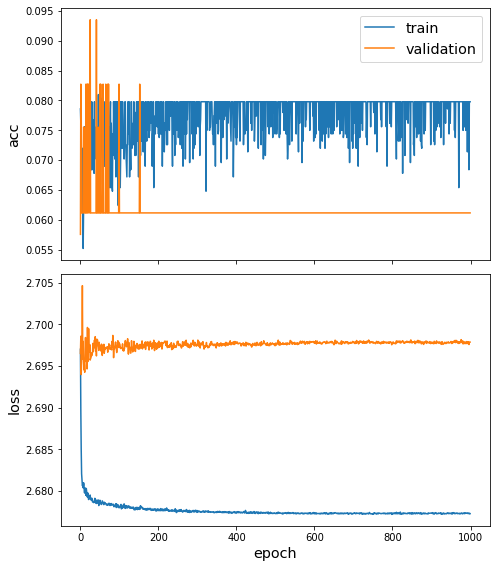

In [21]:
sg.utils.plot_history(history)

In [22]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

278/278 [==============================] - 1s 2ms/step - loss: 2.6908 - acc: 0.0719

Test Set Metrics:
	loss: 2.6908
	acc: 0.0719


In [23]:
Y_prediction = model.predict(test_gen)
y_pred = np.argmax(Y_prediction, axis=1)
y_pred

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int64)

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [25]:
cm = confusion_matrix(graph_labelsOriginal[(len(train_graphs)+ len(val_graphs)):], y_pred)

Confusion matrix, without normalization
[[ 0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 28  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 27  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0]]


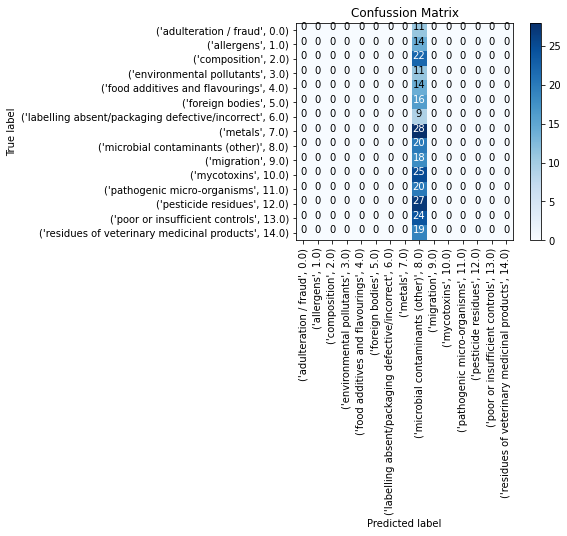

In [26]:
plot_confusion_matrix(cm, y_guide.index, title="Confussion Matrix")